### Imports

In [87]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime
import heapq
import xgboost as xgb
import h5py
from tqdm import tqdm_notebook as tqdm

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize
from keras.models import model_from_json
from keras_tqdm import TQDMNotebookCallback, TQDMCallback

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means

from cyclicLR_callback import CyclicLR

random_seed = 4321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

In [2]:
import keras
keras.__version__

'2.1.2'

In [3]:
import cv2
cv2.__version__

'3.3.0'

Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [4]:
tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [5]:
!nvidia-smi

Wed Jan 24 03:30:05 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   55C    P0    35W / 149W |     72MiB / 11439MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Load Data

In [6]:
data = pd.read_json("data/processed/train.json", orient='records')
data.head()
train_df = data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


In [8]:
for i in tqdm(range(0,100), ascii=True):
    pass

100%|##########| 100/100 [00:00<00:00, 702563.48it/s]


### Missing values

In [9]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
#train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df['inc_angle_f'].replace(np.nan,0, inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,0.0
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,0.0
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,0.0
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,0.0
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,0.0


### Transform for NN

In [10]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

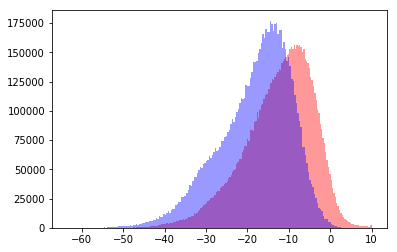

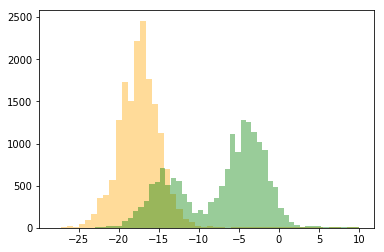

In [11]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

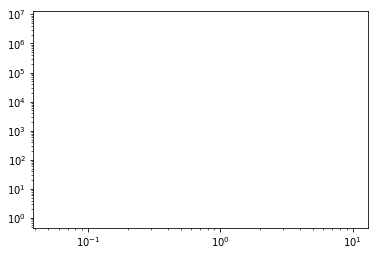

In [12]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

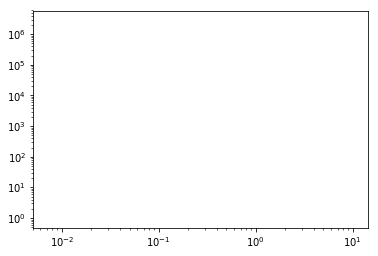

In [13]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

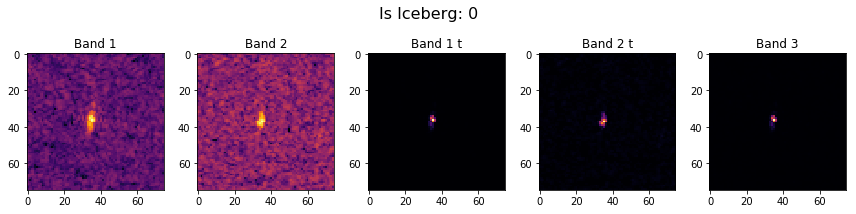

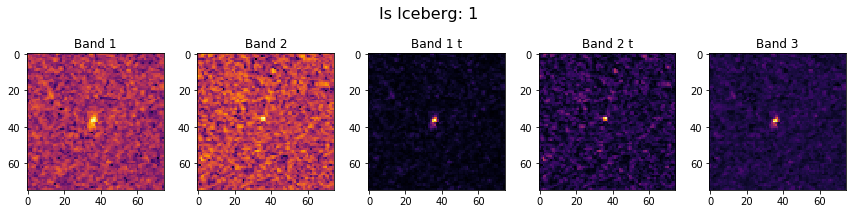

In [14]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


In [15]:
band_3[2].max()

8.4155418416635133

In [16]:
imgs = X[:3,:,:,:2].copy()
imgs.shape

(3, 75, 75, 2)

In [17]:
def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)

In [18]:
def add_noise(img, noise):
    rand_img = np.zeros(img.shape)
    cv2.randn(rand_img,noise[0],noise[1]) 
    return img + rand_img

In [19]:
X[:60,:,:,:2].copy().max()

10.000000000000002

In [20]:
imgs = X[:60,:,:,:2].copy()
apply_over_axis(add_noise, imgs, axis=0, noise=((1,0.5),(1,0.5))).max()

13.235153209793092

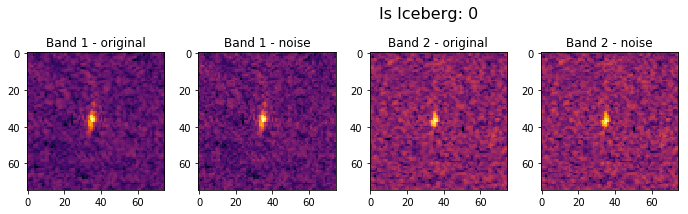

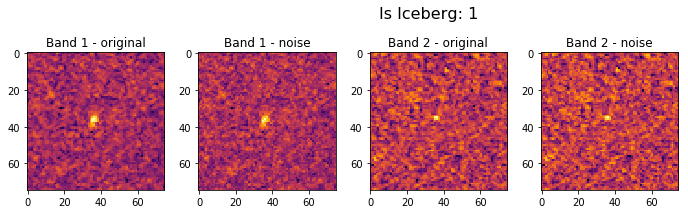

In [21]:
def plot_with_noise(index, cmap="gray"):
    m = (1) 
    s = (1)
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1 - original")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 1 - noise")
    img = band_1[index].copy()
    rand_img = np.zeros((img.shape[0],img.shape[1]))
    cv2.randn(rand_img,m,s);
    img = img + rand_img
    ax2.imshow(img, cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 2 - original")
    ax3.imshow(band_2[index], cmap=cmap)
    ax4 = fig.add_subplot(254)
    ax4.set_title("Band 2 - noise")
    img = band_2[index].copy()
    rand_img = np.zeros((img.shape[0],img.shape[1]))
    m = (0.5) 
    s = (0.5)
    cv2.randn(rand_img,m,s);
    img = img + rand_img
    ax4.imshow(img, cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_with_noise(0,cmap="inferno")
plot_with_noise(2,cmap="inferno")

In [22]:
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index

In [23]:
y_angle.head()

,is_iceberg,inc_angle_f,index
0,0,43.9239,0
1,0,38.1562,1
2,1,45.2859,2
3,0,43.8306,3
4,0,35.6256,4


### Split into train test and validation sets

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.35, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1042, 75, 75, 4)
(562, 75, 75, 4)


In [25]:
X_val_tune, X_val_test, y_val_tune, y_val_test = train_test_split(X_val, y_val, test_size=0.3, random_state=random_seed)
print(X_val_tune.shape)
print(X_val_test.shape)

(393, 75, 75, 4)
(169, 75, 75, 4)


In [26]:
KFolds = [[[X_train[:620],y_train[:620]],[X_train[620:1042],y_train[620:1042]]],
          [[X_train[310:1042],y_train[310:1042]],[X_train[:310],y_train[:310]]],
          [[X_train[155:775],y_train[155:775]],
          [np.append(X_train[:155],X_train[755:1042],axis=0),pd.concat([y_train[:155],y_train[755:1042]])]]]
for tt in tqdm(KFolds, ascii=True):
    print(tt[0][0].shape)
    print(tt[0][1].shape)
    print(tt[1][0].shape)
    print(tt[1][1].shape)

100%|##########| 3/3 [00:00<00:00, 7248.22it/s]

(620, 75, 75, 4)
(620, 3)
(422, 75, 75, 4)
(422, 3)
(732, 75, 75, 4)
(732, 3)
(310, 75, 75, 4)
(310, 3)
(620, 75, 75, 4)
(620, 3)
(442, 75, 75, 4)
(442, 3)


In [27]:
len(KFolds)

3

### Data augmentation

In [28]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

(1042, 75, 75, 4)


In [29]:


datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator, noise=((1,1),(1,1))):
        self.imagegen = imagegen
        self.noise = noise
        self.noise_on = False
        
    def flow(self, x, y, batch_size=8, shuffle=True, noise_on = False, noise=((1,1),(1,1))):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        self.noise=noise
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        if self.noise_on:
            batches = temp_data[0][:,:,:,:4].copy()
            batches = apply_over_axis(add_noise, batches, axis=0, noise=noise)
            temp_stacked1 = batches
            temp_band_3 = batches[:,:,:,2] - batches[:,:,:,3] #band_1_t - band_2_t
        else:
            #temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
            temp_stacked1 = temp_data[0][:,:,:,:2]
            temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        #nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        return [temp_stacked1, temp_stacked2, 
                #nn_denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    



In [30]:

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

### Learning rate scheduler and callback definition

In [31]:
# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001, drop=0.66, patience=5):
        self.initial_lrate=initial_lrate
        self.drop = drop
        self.patience = patience

    def step_decay(self,epoch):
        initial_lrate = self.initial_lrate
        drop = self.drop
        patience = self.patience
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

### Denoising

In [32]:
def denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(ndimage.median_filter(image, 3))
    return np.stack(img_list,axis=2)

In [33]:
#X_denoised = apply_over_axis(denoising, X)

In [34]:
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(12,6))
#fig.suptitle("Denoising: is iceberg: %x" % (y_train_sample.iloc[index,0]), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before")
#ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("Denoised")
#ax2.imshow(X_denoised[original_index][:,:,0], cmap=cmap)
#ax1 = fig.add_subplot(253)
#ax1.set_title("Before - band 2")
#ax1.imshow(X_train_sample[index][:,:,1], cmap=cmap)
#ax2 = fig.add_subplot(254)
#ax2.set_title("Denoised - band 2")
#ax2.imshow(X_denoised[original_index][:,:,1], cmap=cmap)
#plt.show()

### NN denoising

In [35]:
##custom generator for denoising
#from collections import Generator
#class Datagen_denoising(Generator):
#    def __init__(self, imagegen=ImageDataGenerator):
#        self.imagegen = imagegen
#        
#    def flow(self, x, y, batch_size=8, shuffle=True):
#        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
#        return self
#    
#    def send(self, ignored):
#        temp_data = next(self.generator)
#        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
#        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
#                                temp_data[0][:,:,:,3]),axis=3)
#        return temp_stacked, temp_stacked
#    
#    def throw(self, type=None, value=None, traceback=None):
#        raise StopIteration
#        
#datagen_denoising = Datagen_denoising(imagegen=datagen)
#datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)

In [36]:
#m_input = Input(shape=(75,75,4), name='m_input')
#
##conv layers for main_input
#x1 = BatchNormalization()(m_input)
#x1 = ZeroPadding2D()(x1)
#x1 = Conv2D(8, (3,3), activation='relu')(x1)
#x1 = BatchNormalization()(x1)
#x1 = Dropout(0.2)(x1)
#x1 = ZeroPadding2D()(x1)
#x1 = Conv2D(8, (3,3), activation='relu')(x1)
#x1 = BatchNormalization()(x1)
#x1 = Dropout(0.2)(x1)
#x1 = ZeroPadding2D()(x1)
#m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
#model_denoise = Model(inputs=[m_input,], outputs=[m_output], name='Model_nn_denoising')
#
#model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
#loss='mean_squared_error',
#metrics=['mae'])

In [37]:
#model_denoise.summary()

In [38]:
##model training
##lScheduler_denoising = LScheduler(initial_lrate=0.1, drop=0.66, patience=3)
##lrScheduler_denoising = LearningRateScheduler(lScheduler_denoising.step_decay)
#lrScheduler_denoising = CyclicLR(base_lr=1e-8, max_lr=0.006,
#                                 step_size=400, mode='triangular2', gamma=0.99994)
#start_time = time.monotonic()
#
#H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=8),
#                    steps_per_epoch=len(X)/8,
#                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=8, shuffle=False), 
#                    validation_steps=len(X)/8,
#                    #validation_data=[X_val,y_val],
#                    epochs=12,
#                    callbacks = [lrScheduler_denoising, 
#                                 TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
#                    verbose=0)
#
#model_time = time.monotonic() - start_time
#print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
#      + '{:.1f}'.format(model_time % 60) + " seconds")

In [39]:
#h = lrScheduler_denoising.history
#plt.plot(h['lr'], color="b", label='lr')
#plt.legend()
#plt.xlabel('# iterations')
#plt.show()

In [40]:
## serialize model to JSON
#model_json = model_denoise.to_json()
#with open("models/model_denoise.json", "w") as json_file:
#    json_file.write(model_json)

In [41]:
## serialize weights to HDF5
#model_weights = model_denoise.get_weights()
#with open('models/model_denoise_weights.pickle', 'wb') as handle:
#    pickle.dump(model_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
## load json and create model
#with open("models/model_denoise.json", "r") as json_file:
#    loaded_model_json = json_file.read()
#model_denoise = model_from_json(loaded_model_json)
## load weights into new model
#with open('models/model_denoise_weights.pickle', 'rb') as handle:
#    model_weights = pickle.load(handle)
#model_denoise.set_weights(model_weights)
#print("Loaded model from disk")

In [43]:
#X_nn_denoised = model_denoise.predict(X, verbose=1)

In [44]:
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(12,6))
#fig.suptitle("Image denoising nn: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before band_1")
#ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("NN Denoising band 1")
#ax2.imshow(X_nn_denoised[original_index][:,:,0], cmap=cmap)
#ax3 = fig.add_subplot(253)
#ax3.set_title("Before band 2")
#ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
#ax4 = fig.add_subplot(254)
#ax4.set_title("NN Denoising band 2")
#ax4.imshow(X_nn_denoised[original_index][:,:,1], cmap=cmap)
#plt.show()

### Keras model

In [45]:
model_code="CNN_2018_01_23_v02"
model_comment="2 CNN inputs 3,3 conv filters, na=0"

In [46]:
%%writefile current_model.py

def InputBlock(x, dropout=0.2, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
    #aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input')
x2 = InputBlock(aux_input, prefix='a_input')
    #x3 = model_denoise(aux_input_nn)
    #x3 = InputBlock(x3,dropout=0.3, prefix='a_input_nn')

    #x = x1
x = Concatenate(axis=3)([x1,x2])
    #x = BatchNormalization()(x)
    #x = Dropout(0.2)(x)

    #conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

    #conv-block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
    #flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
    #x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, angle_input])
    
    #dense-block
x = Dense(513, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
    #dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                            #aux_input_nn, 
                            angle_input], 
                            outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
    loss='binary_crossentropy',
    metrics=['accuracy'])
    

Overwriting current_model.py


In [47]:
%run -i current_model.py

In [48]:
#model_f = build_model()

In [49]:
class ModelHistory(Callback):
    def __init__(self, listSize=10):
        self.listSize = listSize
        self.models = []

    def on_epoch_end(self, epoch, logs={}):
        lastLoss = logs.get('val_loss')
        rank = - lastLoss
        if len(self.models) > 0:
            if rank > self.models[0][0]: # new model is better than the worst in the heap
                if len(self.models) >= self.listSize: #if the model heap is already full
                    heapq.heappushpop(self.models, (rank, lastLoss, self.model.get_weights()))
                else:
                    heapq.heappush(self.models, (rank, lastLoss, self.model.get_weights()))
        else:
            heapq.heappush(self.models, (rank, lastLoss, self.model.get_weights()))

def get_callbacks(filepath, save_to_disc = True, lScheduler = None,
                  patience=10, step_decay=LScheduler().step_decay, modelHistoryCallback=None):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    if lScheduler is None:
        lrScheduler = LearningRateScheduler(step_decay)
    else:
        lrScheduler = lScheduler
    tqdmCallback =  TQDMNotebookCallback(leave_inner=True, leave_outer=True, ascii=True)
    if (save_to_disc):
        return [msave, lrScheduler, modelHistoryCallback]
    else:
        return [lrScheduler, modelHistoryCallback]

In [50]:
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 2)    8           main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 75, 75, 3)    12          aux_input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (

In [51]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
#SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

### Model Training

In [52]:
#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
#lScheduler = LScheduler(initial_lrate=0.001, drop=0.66, patience=7)

In [53]:
#addtional training epochs - warm start
#lScheduler = LScheduler(initial_lrate=0.000001, drop=0.66, patience=3)
modelEnsemble2 = ModelHistory(listSize=1)
lScheduler = CyclicLR(base_lr=0.001, max_lr=0.003,
                                 step_size=10, mode='triangular3', beta=0.33, theta=0.22)
callbacks = get_callbacks(filepath=model_best_weights_path, save_to_disc=False, lScheduler=lScheduler,
                          modelHistoryCallback=modelEnsemble2)
model_f.compile(optimizer=Adam(lr=1e-7),loss='binary_crossentropy',metrics=['accuracy'])
start_time = time.monotonic()

H1 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=256, shuffle=True, 
                                             noise_on=True,noise=((0.5,0.25,5,0.25),(0.5,0.25,5,0.25))),
                    steps_per_epoch=len(X_train_sample)/256,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=48, shuffle=False, 
                                             noise_on=True,noise=((0.5,0.25,5,0.25),(0.5,0.25,5,0.25))), 
                    validation_steps=len(X_val)/48,
                    #validation_data=[X_val,y_val],
                    epochs=50, callbacks=callbacks,
                    verbose=1)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Epoch 1/50
5/4 [====================================] - 7s 1s/step - loss: 0.7520 - acc: 0.6441 - val_loss: 1.5485 - val_acc: 0.5480
Epoch 2/50
5/4 [====================================] - 3s 526ms/step - loss: 0.5761 - acc: 0.7388 - val_loss: 3.5372 - val_acc: 0.5409
Epoch 3/50
5/4 [====================================] - 3s 522ms/step - loss: 0.5647 - acc: 0.7503 - val_loss: 5.7315 - val_acc: 0.5427
Epoch 4/50
5/4 [====================================] - 3s 524ms/step - loss: 0.4706 - acc: 0.7719 - val_loss: 4.9142 - val_acc: 0.5374
Epoch 5/50
5/4 [====================================] - 3s 521ms/step - loss: 0.4387 - acc: 0.8009 - val_loss: 3.6795 - val_acc: 0.5463
Epoch 6/50
5/4 [====================================] - 3s 524ms/step - loss: 0.4209 - acc: 0.7912 - val_loss: 2.4416 - val_acc: 0.5409
Epoch 7/50
5/4 [====================================] - 3s 523ms/step - loss: 0.4218 - acc: 0.8120 - val_loss: 3.1232 - val_acc: 0.5427
Epoch 8/50
5/4 [===================================

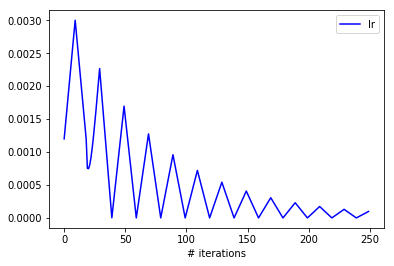

In [54]:
h = lScheduler.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

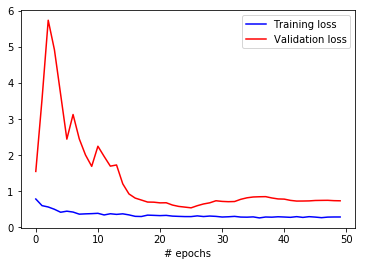

In [55]:
plt.plot(H1.history['loss'], color="b", label='Training loss')
plt.plot(H1.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [56]:
#model training
start_time = time.monotonic()
lScheduler = None
modelEnsemble = ModelHistory(listSize=120)
H=[]
for i in tqdm(range(8), ascii = True):
    x_train_tmp, x_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train, y_train, test_size=0.3)
    modelEnsemble_tmp = ModelHistory(listSize=30)
    lScheduler_tmp = CyclicLR(base_lr=0.0001, max_lr=0.001,
                                 step_size=10, mode='triangular3', beta=0.22, theta=0.11)
    callbacks = get_callbacks(filepath=model_best_weights_path, save_to_disc=False, lScheduler=lScheduler_tmp,
                          modelHistoryCallback=modelEnsemble_tmp)    
    #model_f = build_model()
    H_tmp = model_f.fit_generator(datagen_angle.flow(x_train_tmp, y_train_tmp, batch_size=128, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))), #add noise mean(4 channel) and sigma(4 channels)
                    steps_per_epoch=len(x_train_tmp)/128,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=40, shuffle=False, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))), 
                    validation_steps=len(X_val)/40,
                    #validation_data=[X_val,y_val],
                    epochs=30, callbacks=callbacks,
                    verbose=1)
    H.append(H_tmp)
    lScheduler = lScheduler_tmp
    for model_weights in modelEnsemble_tmp.models:
        heapq.heappush(modelEnsemble.models, model_weights)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/30
6/5 [===============================] - 4s 684ms/step - loss: 0.2888 - acc: 0.8800 - val_loss: 0.7407 - val_acc: 0.6726
Epoch 2/30
6/5 [===============================] - 2s 347ms/step - loss: 0.3033 - acc: 0.8554 - val_loss: 0.9867 - val_acc: 0.6192
Epoch 3/30
6/5 [===============================] - 2s 345ms/step - loss: 0.3001 - acc: 0.8598 - val_loss: 1.0267 - val_acc: 0.6068
Epoch 4/30
6/5 [===============================] - 2s 349ms/step - loss: 0.2962 - acc: 0.8672 - val_loss: 0.9150 - val_acc: 0.6406
Epoch 5/30
6/5 [===============================] - 2s 347ms/step - loss: 0.3170 - acc: 0.8646 - val_loss: 0.7443 - val_acc: 0.7100
Epoch 6/30
6/5 [===============================] - 2s 348ms/step - loss: 0.3047 - acc: 0.8741 - val_loss: 0.9614 - val_acc: 0.6263
Epoch 7/30
6/5 [===============================] - 2s 348ms/step - loss: 0.2668 - acc: 0.8939 - val_loss: 0.9617 - val_acc: 0.6281
Epoch 8/30
6/5 [===============================] - 2s 348ms/step - loss: 0.2478 - a

 12%|#2        | 1/8 [01:05<07:35, 65.00s/it]

Epoch 1/30
6/5 [===============================] - 2s 382ms/step - loss: 0.2293 - acc: 0.8951 - val_loss: 0.5104 - val_acc: 0.8203
Epoch 2/30
6/5 [===============================] - 2s 353ms/step - loss: 0.2398 - acc: 0.9060 - val_loss: 0.4073 - val_acc: 0.8594
Epoch 3/30
6/5 [===============================] - 2s 348ms/step - loss: 0.2328 - acc: 0.8987 - val_loss: 0.3391 - val_acc: 0.8701
Epoch 4/30
6/5 [===============================] - 2s 349ms/step - loss: 0.2423 - acc: 0.8969 - val_loss: 0.3641 - val_acc: 0.8683
Epoch 5/30
6/5 [===============================] - 2s 350ms/step - loss: 0.2245 - acc: 0.8970 - val_loss: 0.4056 - val_acc: 0.8541
Epoch 6/30
6/5 [===============================] - 2s 349ms/step - loss: 0.2261 - acc: 0.9021 - val_loss: 0.3674 - val_acc: 0.8683
Epoch 7/30
6/5 [===============================] - 2s 349ms/step - loss: 0.2000 - acc: 0.9197 - val_loss: 0.3619 - val_acc: 0.8701
Epoch 8/30
6/5 [===============================] - 2s 349ms/step - loss: 0.2321 - a

 25%|##5       | 2/8 [02:08<06:24, 64.16s/it]

Epoch 1/30
6/5 [===============================] - 2s 380ms/step - loss: 0.2023 - acc: 0.9111 - val_loss: 0.2775 - val_acc: 0.8986
Epoch 2/30
6/5 [===============================] - 2s 350ms/step - loss: 0.2077 - acc: 0.9051 - val_loss: 0.2503 - val_acc: 0.8968
Epoch 3/30
6/5 [===============================] - 2s 350ms/step - loss: 0.2481 - acc: 0.9015 - val_loss: 0.2670 - val_acc: 0.9039
Epoch 4/30
6/5 [===============================] - 2s 349ms/step - loss: 0.2153 - acc: 0.8895 - val_loss: 0.2713 - val_acc: 0.9021
Epoch 5/30
6/5 [===============================] - 2s 350ms/step - loss: 0.2277 - acc: 0.9084 - val_loss: 0.2592 - val_acc: 0.8950
Epoch 6/30
6/5 [===============================] - 2s 349ms/step - loss: 0.2031 - acc: 0.9100 - val_loss: 0.2529 - val_acc: 0.9093
Epoch 7/30
6/5 [===============================] - 2s 351ms/step - loss: 0.1853 - acc: 0.9177 - val_loss: 0.2478 - val_acc: 0.9057
Epoch 8/30
6/5 [===============================] - 2s 349ms/step - loss: 0.1947 - a

 38%|###7      | 3/8 [03:11<05:19, 63.91s/it]

Epoch 1/30
6/5 [===============================] - 2s 381ms/step - loss: 0.1851 - acc: 0.9254 - val_loss: 0.3876 - val_acc: 0.8790
Epoch 2/30
6/5 [===============================] - 2s 354ms/step - loss: 0.2424 - acc: 0.9105 - val_loss: 0.3633 - val_acc: 0.8772
Epoch 3/30
6/5 [===============================] - 2s 348ms/step - loss: 0.1867 - acc: 0.9239 - val_loss: 0.2619 - val_acc: 0.8986
Epoch 4/30
6/5 [===============================] - 2s 351ms/step - loss: 0.1987 - acc: 0.9179 - val_loss: 0.2488 - val_acc: 0.9057
Epoch 5/30
6/5 [===============================] - 2s 351ms/step - loss: 0.2126 - acc: 0.9087 - val_loss: 0.2679 - val_acc: 0.9021
Epoch 6/30
6/5 [===============================] - 2s 352ms/step - loss: 0.1982 - acc: 0.9113 - val_loss: 0.2436 - val_acc: 0.9093
Epoch 7/30
6/5 [===============================] - 2s 350ms/step - loss: 0.2153 - acc: 0.9031 - val_loss: 0.2454 - val_acc: 0.9021
Epoch 8/30
6/5 [===============================] - 2s 348ms/step - loss: 0.1706 - a

 50%|#####     | 4/8 [04:15<04:15, 63.78s/it]

Epoch 1/30
6/5 [===============================] - 2s 382ms/step - loss: 0.1521 - acc: 0.9438 - val_loss: 0.3013 - val_acc: 0.9021
Epoch 2/30
6/5 [===============================] - 2s 350ms/step - loss: 0.1941 - acc: 0.9131 - val_loss: 0.2698 - val_acc: 0.9146
Epoch 3/30
6/5 [===============================] - 2s 350ms/step - loss: 0.1711 - acc: 0.9246 - val_loss: 0.3054 - val_acc: 0.8986
Epoch 4/30
6/5 [===============================] - 2s 347ms/step - loss: 0.1320 - acc: 0.9456 - val_loss: 0.2862 - val_acc: 0.8968
Epoch 5/30
6/5 [===============================] - 2s 349ms/step - loss: 0.1575 - acc: 0.9336 - val_loss: 0.2642 - val_acc: 0.9199
Epoch 6/30
6/5 [===============================] - 2s 349ms/step - loss: 0.1600 - acc: 0.9315 - val_loss: 0.2741 - val_acc: 0.9075
Epoch 7/30
6/5 [===============================] - 2s 349ms/step - loss: 0.1381 - acc: 0.9529 - val_loss: 0.2557 - val_acc: 0.9110
Epoch 8/30
6/5 [===============================] - 2s 349ms/step - loss: 0.1329 - a

 62%|######2   | 5/8 [05:18<03:11, 63.71s/it]

Epoch 1/30
6/5 [===============================] - 2s 384ms/step - loss: 0.1503 - acc: 0.9364 - val_loss: 0.3107 - val_acc: 0.9075
Epoch 2/30
6/5 [===============================] - 2s 351ms/step - loss: 0.1714 - acc: 0.9320 - val_loss: 0.2640 - val_acc: 0.9093
Epoch 3/30
6/5 [===============================] - 2s 351ms/step - loss: 0.1631 - acc: 0.9285 - val_loss: 0.2529 - val_acc: 0.9128
Epoch 4/30
6/5 [===============================] - 2s 350ms/step - loss: 0.1687 - acc: 0.9336 - val_loss: 0.2353 - val_acc: 0.9057
Epoch 5/30
6/5 [===============================] - 2s 350ms/step - loss: 0.1560 - acc: 0.9341 - val_loss: 0.2562 - val_acc: 0.9235
Epoch 6/30
6/5 [===============================] - 2s 352ms/step - loss: 0.1518 - acc: 0.9449 - val_loss: 0.2760 - val_acc: 0.8986
Epoch 7/30
6/5 [===============================] - 2s 350ms/step - loss: 0.1489 - acc: 0.9439 - val_loss: 0.2615 - val_acc: 0.9004
Epoch 8/30
6/5 [===============================] - 2s 354ms/step - loss: 0.1329 - a

 75%|#######5  | 6/8 [06:22<02:07, 63.73s/it]

Epoch 1/30
6/5 [===============================] - 2s 383ms/step - loss: 0.1625 - acc: 0.9352 - val_loss: 0.2782 - val_acc: 0.9075
Epoch 2/30
6/5 [===============================] - 2s 353ms/step - loss: 0.1401 - acc: 0.9387 - val_loss: 0.3325 - val_acc: 0.8986
Epoch 3/30
6/5 [===============================] - 2s 352ms/step - loss: 0.1546 - acc: 0.9354 - val_loss: 0.2608 - val_acc: 0.9146
Epoch 4/30
6/5 [===============================] - 2s 349ms/step - loss: 0.1554 - acc: 0.9367 - val_loss: 0.2764 - val_acc: 0.9146
Epoch 5/30
6/5 [===============================] - 2s 349ms/step - loss: 0.1512 - acc: 0.9388 - val_loss: 0.3277 - val_acc: 0.9093
Epoch 6/30
6/5 [===============================] - 2s 351ms/step - loss: 0.1317 - acc: 0.9410 - val_loss: 0.2932 - val_acc: 0.9075
Epoch 7/30
6/5 [===============================] - 2s 349ms/step - loss: 0.1282 - acc: 0.9525 - val_loss: 0.2847 - val_acc: 0.9057
Epoch 8/30
6/5 [===============================] - 2s 349ms/step - loss: 0.1326 - a

 88%|########7 | 7/8 [07:25<01:03, 63.70s/it]

Epoch 1/30
6/5 [===============================] - 2s 388ms/step - loss: 0.1192 - acc: 0.9492 - val_loss: 0.3681 - val_acc: 0.9128
Epoch 2/30
6/5 [===============================] - 2s 352ms/step - loss: 0.1767 - acc: 0.9318 - val_loss: 0.3628 - val_acc: 0.9093
Epoch 3/30
6/5 [===============================] - 2s 351ms/step - loss: 0.1446 - acc: 0.9429 - val_loss: 0.2969 - val_acc: 0.9039
Epoch 4/30
6/5 [===============================] - 2s 350ms/step - loss: 0.1215 - acc: 0.9539 - val_loss: 0.3019 - val_acc: 0.9075
Epoch 5/30
6/5 [===============================] - 2s 352ms/step - loss: 0.1436 - acc: 0.9393 - val_loss: 0.3619 - val_acc: 0.9093
Epoch 6/30
6/5 [===============================] - 2s 351ms/step - loss: 0.1654 - acc: 0.9290 - val_loss: 0.3105 - val_acc: 0.9075
Epoch 7/30
6/5 [===============================] - 2s 350ms/step - loss: 0.1077 - acc: 0.9538 - val_loss: 0.3081 - val_acc: 0.9146
Epoch 8/30
6/5 [===============================] - 2s 350ms/step - loss: 0.1281 - a

100%|##########| 8/8 [08:29<00:00, 63.68s/it]

Model training time: 8 minutes 29.5 seconds


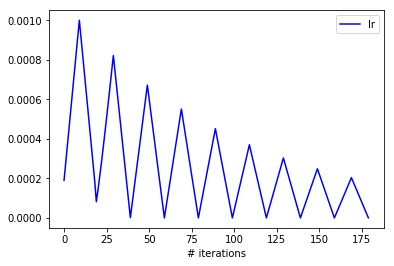

In [57]:
h = lScheduler.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

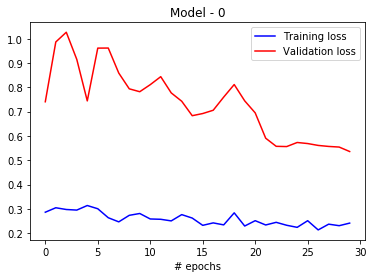

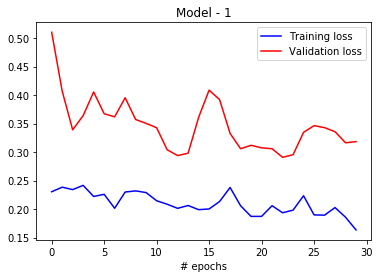

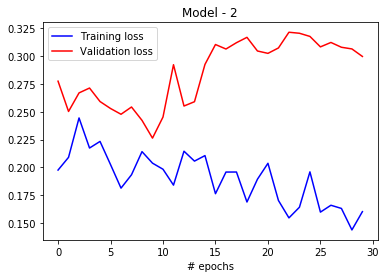

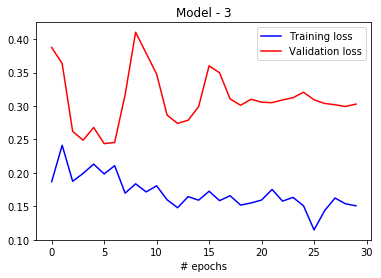

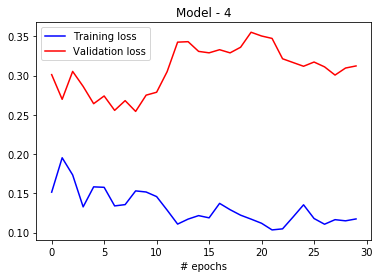

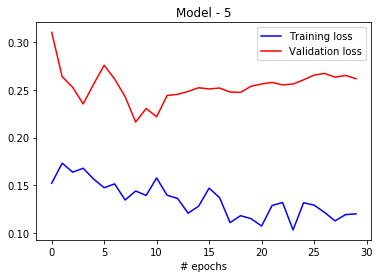

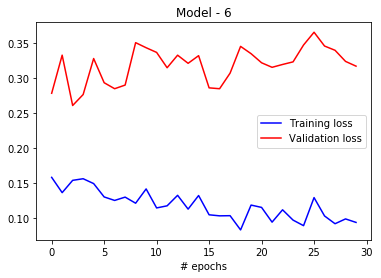

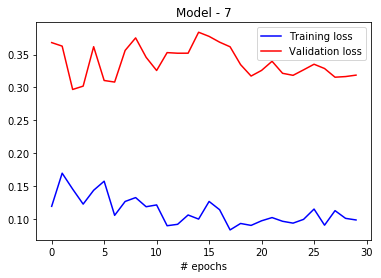

In [58]:
for i,hist in enumerate(H):
    plt.plot(hist.history['loss'], color="b", label='Training loss')
    plt.plot(hist.history['val_loss'], color="r", label='Validation loss')
    plt.legend()
    plt.title("Model - " + str(i))
    plt.xlabel('# epochs')
    plt.show()

In [59]:
heapq.nlargest(1,modelEnsemble.models)[0]

(-0.21634197233781696,
 0.21634197233781696,
 [array([ 0.97832751,  1.01841521], dtype=float32),
  array([-0.0108087 , -0.01096368], dtype=float32),
  array([-12.46663284, -18.05713844], dtype=float32),
  array([ 70.01511383,  76.70845795], dtype=float32),
  array([ 0.98076969,  1.02961051,  0.97327954], dtype=float32),
  array([-0.03178436, -0.01509656, -0.00322011], dtype=float32),
  array([ 0.20688397,  0.05933251,  0.14755142], dtype=float32),
  array([ 0.19650871,  0.01318616,  0.1585463 ], dtype=float32),
  array([[[[ 0.07039892,  0.07715011, -0.09597782, ...,  0.02421183,
             0.09232469, -0.08048195],
           [ 0.0854241 ,  0.0631468 , -0.08716742, ..., -0.10256783,
            -0.01363196,  0.05994009]],
  
          [[-0.06947736,  0.03262098,  0.05467854, ..., -0.03238899,
            -0.01071444, -0.01722796],
           [ 0.02792383,  0.01776045,  0.08160447, ...,  0.07631867,
            -0.01941645, -0.04036381]],
  
          [[-0.07686071,  0.07627397,  0.09

In [60]:
model_f.set_weights(heapq.nlargest(1,modelEnsemble.models)[0][2])

### Additional training epochs  - warm start

In [61]:
#addtional training epochs - warm start
#lScheduler = LScheduler(initial_lrate=0.000001, drop=0.66, patience=3)
modelEnsemble2 = ModelHistory(listSize=15)
lScheduler = CyclicLR(base_lr=0.00003, max_lr=0.0003,
                                 step_size=10, mode='triangular3', beta=0.33, theta=0.22)
callbacks = get_callbacks(filepath=model_best_weights_path, save_to_disc=False, lScheduler=lScheduler,
                          modelHistoryCallback=modelEnsemble2)
model_f.compile(optimizer=Adam(lr=1e-7),loss='binary_crossentropy',metrics=['accuracy'])
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=256, shuffle=True, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))),
                    steps_per_epoch=len(X_train_sample)/256,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=48, shuffle=False, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))), 
                    validation_steps=len(X_val)/48,
                    #validation_data=[X_val,y_val],
                    epochs=80, callbacks=callbacks,
                    verbose=1)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Epoch 1/80
5/4 [====================================] - 4s 842ms/step - loss: 0.1539 - acc: 0.9362 - val_loss: 0.2239 - val_acc: 0.9199
Epoch 2/80
5/4 [====================================] - 3s 533ms/step - loss: 0.1856 - acc: 0.9231 - val_loss: 0.2696 - val_acc: 0.9075
Epoch 3/80
5/4 [====================================] - 3s 534ms/step - loss: 0.1838 - acc: 0.9067 - val_loss: 0.3082 - val_acc: 0.9075
Epoch 4/80
5/4 [====================================] - 3s 536ms/step - loss: 0.1538 - acc: 0.9271 - val_loss: 0.2951 - val_acc: 0.8968
Epoch 5/80
5/4 [====================================] - 3s 531ms/step - loss: 0.2173 - acc: 0.9374 - val_loss: 0.2880 - val_acc: 0.9057
Epoch 6/80
5/4 [====================================] - 3s 531ms/step - loss: 0.1425 - acc: 0.9476 - val_loss: 0.2796 - val_acc: 0.9021
Epoch 7/80
5/4 [====================================] - 3s 531ms/step - loss: 0.1955 - acc: 0.9202 - val_loss: 0.2597 - val_acc: 0.9021
Epoch 8/80
5/4 [================================

Epoch 61/80
5/4 [====================================] - 3s 533ms/step - loss: 0.1377 - acc: 0.9444 - val_loss: 0.2560 - val_acc: 0.9181
Epoch 62/80
5/4 [====================================] - 3s 534ms/step - loss: 0.1187 - acc: 0.9517 - val_loss: 0.2559 - val_acc: 0.9181
Epoch 63/80
5/4 [====================================] - 3s 534ms/step - loss: 0.1264 - acc: 0.9508 - val_loss: 0.2555 - val_acc: 0.9181
Epoch 64/80
5/4 [====================================] - 3s 533ms/step - loss: 0.1119 - acc: 0.9611 - val_loss: 0.2553 - val_acc: 0.9181
Epoch 65/80
5/4 [====================================] - 3s 537ms/step - loss: 0.1289 - acc: 0.9444 - val_loss: 0.2549 - val_acc: 0.9181
Epoch 66/80
5/4 [====================================] - 3s 533ms/step - loss: 0.1601 - acc: 0.9279 - val_loss: 0.2549 - val_acc: 0.9181
Epoch 67/80
5/4 [====================================] - 3s 539ms/step - loss: 0.1423 - acc: 0.9430 - val_loss: 0.2555 - val_acc: 0.9181
Epoch 68/80
5/4 [========================

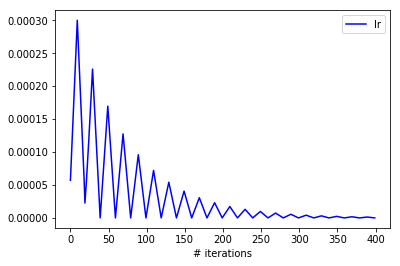

In [62]:
h = lScheduler.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

In [63]:
for key in H1.history:
    H1.history[key].extend(H2.history[key])

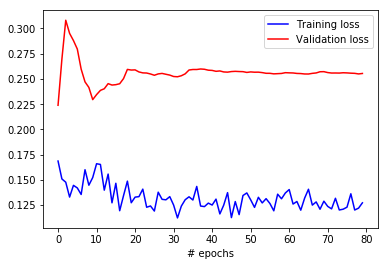

In [64]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

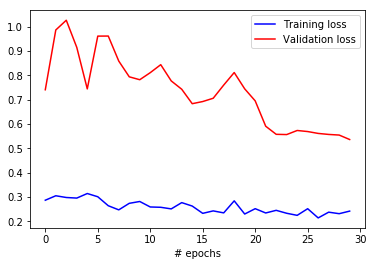

In [65]:
plt.plot(H[0].history['loss'], color="b", label='Training loss')
plt.plot(H[0].history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [66]:
# serialize model to JSON
model_json = model_f.to_json()
with open("models/model_gcompute_v1.json", "w") as json_file:
    json_file.write(model_json)

In [67]:
# load model from JSON - don't care about the weights rith now, they are saved separately
with open("models/model_gcompute_v1.json", "r") as json_file:
    loaded_model_json = json_file.read()
    model_f = model_from_json(loaded_model_json)

In [68]:
#model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
#model_f.save('models/last_model.hdf5') //crashes python kernel with Keras version 2.1.2
#model_f = load_model(model_object_path)

In [69]:
for model_weights in modelEnsemble2.models:
    heapq.heappush(modelEnsemble.models, model_weights)

In [70]:
with open('models/modelEnsemble_volta_v28.pickle', 'wb') as handle:
    pickle.dump(modelEnsemble.models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
modelEnsemble = ModelHistory(listSize=106)
with open('models/modelEnsemble_volta_v28.pickle', 'rb') as handle:
    modelEnsemble.models = pickle.load(handle)

### Saving model history

In [72]:
#argmin = np.array(H.history["loss"]).argmin()
#argmin

In [73]:
#argmin = np.array(H.history["val_loss"]).argmin()
#argmax_acc = np.array(H.history["val_acc"]).argmax()
#with open('current_model.py','r') as model_python_code_file:
#    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
#                                    "val_loss [min]":[H.history['val_loss'][argmin]],
#                                    "epoch [val_loss [min]]":argmin,
#                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
#                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
#                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
#                                    
#                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
#                                    "epoch [val_acc [max]]":argmax_acc,
#                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
#                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
#                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
#                                    
#                                    "model_path":[model_object_path],
#                                    "model_weights_path":[model_best_weights_path],
#                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
#                                    "model_comment":[model_comment]
#                                })
#                               
#models_history = models_history[["timestamp", 
#                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
#                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
#                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
#                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
#                                 "model_path","model_weights_path","model_python_code","model_comment"]]
#models_history.head()

In [74]:
#print("Min validation loss epoch:")
#print("epoch: %d" %(argmin),
#      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
#      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
#      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
#      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
#     )
#print("Max validation accuracy epoch:")
#print("epoch: %d" %(argmax_acc),
#      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
#      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
#      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
#      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
#     )
#print("model comment:", model_comment)
#

In [75]:
#with open('models_history.csv', 'a') as f:
#    models_history.to_csv(f, header=False,index=False)
#    #models_history.to_csv(f, index=False)

In [76]:
#df = pd.read_csv('models_history.csv')
#df.tail()

### Model Ensemble

In [77]:
model_f.set_weights(heapq.nlargest(1,modelEnsemble.models)[0][2])
model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])
model_f.evaluate_generator(datagen_angle_val.flow(X_val, y_val, batch_size=16, shuffle=True, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))), 
                           steps = len(X)/6)

[0.21641688300447567, 0.92147971360381864]

In [83]:
def get_prediction(model,weights, X, y):
    model.set_weights(weights)
    return model.predict_generator(datagen_angle_val.flow(X, y, batch_size=256, shuffle=False, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))), 
                           steps = len(X)/255, verbose=0)

In [84]:
def get_ensemble_predictions(X, y, modelEnsemble):
    predictions = [get_prediction(model_f, model[2], X, y)[:X.shape[0]]
                   for model in tqdm(modelEnsemble.models)]    
    temp_array = np.array(predictions)
    del(predictions)
    temp_array = np.swapaxes(temp_array,0,1)
    temp_array = temp_array.reshape(temp_array.shape[0],temp_array.shape[1])
    return temp_array

In [80]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_train = hf['ensemble_train'][:]

In [85]:
modelEnsemble.models[0][1]

0.74071302659995186

In [89]:
ensemble_val = get_ensemble_predictions(X_val_tune, y_val_tune, modelEnsemble)
ensemble_val_test = get_ensemble_predictions(X_val_test, y_val_test, modelEnsemble)

HBox(children=(IntProgress(value=0, max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, max=157), HTML(value='')))

In [154]:
ensemble_train = get_ensemble_predictions(np.append(X_train,X_val_tune,axis=0), pd.concat([y_train,y_val_tune]), modelEnsemble)

HBox(children=(IntProgress(value=0, max=157), HTML(value='')))

In [155]:
y_train_val_tune = pd.concat([y_train,y_val_tune])

In [90]:
with h5py.File('tmp_data/ensemble_data.h5', 'w') as hf:
    hf.create_dataset("ensemble_val",  data=ensemble_val)
ensemble_val.shape

(393, 157)

In [91]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_val = hf['ensemble_val'][:]

In [92]:
ensemble_val.shape

(393, 157)

In [93]:
y_val.shape

(562, 3)

In [94]:
with h5py.File('tmp_data/ensemble_data.h5', 'w') as hf:
    hf.create_dataset("ensemble_val_test",  data=ensemble_val)
ensemble_val.shape

(393, 157)

In [101]:
def modelfit(alg, X, y , X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    dtest_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("n_estimators: %d" % cvresult.shape[0])
    print("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print("Log loss (Train): %f" % metrics.log_loss(y, dtrain_predprob))
    print("Log loss (Test): %f" % metrics.log_loss(y_test, dtest_predprob))


In [96]:
#ensemble_train = get_ensemble_predictions(X_train, y_train, modelEnsemble)
#with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
#    hf.create_dataset("ensemble_train",  data=ensemble_train)

In [97]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_train = hf['ensemble_train'][:]

In [98]:
#ensemble_train.shape

In [102]:
#ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

### Fine tuning ensemble using xgboost

In [103]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, ensemble_val, y_val_tune['is_iceberg'], ensemble_val_test, y_val_test['is_iceberg'])


Model Report
n_estimators: 35
Accuracy : 0.9873
Log loss (Train): 0.073183
Log loss (Test): 0.134417


In [104]:
#ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

In [129]:
param_test1 = {
 'max_depth':list(range(3,13,2)),
 'min_child_weight':list(range(1,10,2))
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=35, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=1,iid=False, cv=3, verbose=1)
gsearch1.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    4.3s finished
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.23970, std: 0.03806, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.23580, std: 0.03559, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.23820, std: 0.04409, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.23821, std: 0.04392, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: -0.24664, std: 0.04536, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: -0.24567, std: 0.04222, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.23727, std: 0.03467, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.23820, std: 0.04409, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.23821, std: 0.04392, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: -0.24664, std: 0.04536, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: -0.24883, std: 0.04032, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.23727, std: 0.03467, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.23820, std: 0.044

In [124]:
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 5}

In [130]:
param_test2 = {
 'max_depth':[gsearch1.best_params_['max_depth']-1,gsearch1.best_params_['max_depth'],gsearch1.best_params_['max_depth']+1],
 'min_child_weight':[gsearch1.best_params_['min_child_weight']-0.5,
                     gsearch1.best_params_['min_child_weight'],
                     gsearch1.best_params_['min_child_weight']+0.5]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=35, 
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'], 
    gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test2, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch2.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    2.8s finished
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.23441, std: 0.07275, params: {'max_depth': 2, 'min_child_weight': 2.5},
  mean: -0.23154, std: 0.06794, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: -0.22945, std: 0.07025, params: {'max_depth': 2, 'min_child_weight': 3.5},
  mean: -0.23749, std: 0.05988, params: {'max_depth': 3, 'min_child_weight': 2.5},
  mean: -0.23465, std: 0.05935, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.22794, std: 0.06586, params: {'max_depth': 3, 'min_child_weight': 3.5},
  mean: -0.23764, std: 0.06471, params: {'max_depth': 4, 'min_child_weight': 2.5},
  mean: -0.23253, std: 0.06062, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.22536, std: 0.06276, params: {'max_depth': 4, 'min_child_weight': 3.5}],
 {'max_depth': 4, 'min_child_weight': 3.5},
 -0.22536016010123863)

In [126]:
param_test3 = {
 'gamma':[i/20.0 for i in range(0,30)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=35, max_depth=3,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test3, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch3.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.6s finished
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.22927, std: 0.06875, params: {'gamma': 0.0},
  mean: -0.23005, std: 0.06928, params: {'gamma': 0.05},
  mean: -0.23120, std: 0.06934, params: {'gamma': 0.1},
  mean: -0.23159, std: 0.06859, params: {'gamma': 0.15},
  mean: -0.23057, std: 0.06877, params: {'gamma': 0.2},
  mean: -0.23047, std: 0.06878, params: {'gamma': 0.25},
  mean: -0.23039, std: 0.06888, params: {'gamma': 0.3},
  mean: -0.23029, std: 0.06859, params: {'gamma': 0.35},
  mean: -0.23034, std: 0.06854, params: {'gamma': 0.4},
  mean: -0.23074, std: 0.06815, params: {'gamma': 0.45},
  mean: -0.22986, std: 0.06874, params: {'gamma': 0.5},
  mean: -0.22969, std: 0.06881, params: {'gamma': 0.55},
  mean: -0.22976, std: 0.06879, params: {'gamma': 0.6},
  mean: -0.23021, std: 0.06828, params: {'gamma': 0.65},
  mean: -0.23020, std: 0.06829, params: {'gamma': 0.7},
  mean: -0.23020, std: 0.06829, params: {'gamma': 0.75},
  mean: -0.23229, std: 0.06815, params: {'gamma': 0.8},
  mean: -0.23166, std: 0.06833, params: 

In [136]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=3,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, ensemble_val, y_val_tune['is_iceberg'],ensemble_val_test, y_val_test['is_iceberg'])


Model Report
n_estimators: 40
Accuracy : 0.9796
Log loss (Train): 0.100664
Log loss (Test): 0.149973


In [137]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test4, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch4.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    6.1s finished
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.23533, std: 0.06613, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.23581, std: 0.06237, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.23338, std: 0.05952, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.24178, std: 0.06551, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.24030, std: 0.07369, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.23675, std: 0.06229, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.23590, std: 0.06058, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -0.23652, std: 0.06382, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -0.23631, std: 0.07204, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -0.23187, std: 0.06479, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -0.23474, std: 0.06332, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -0.23924, std: 0.06598, params: {'colsample_bytree': 0.8,

In [138]:
param_test5 = {
 'subsample':[i/100.0 for i in range(50,80,5)],
 'colsample_bytree':[i/100.0 for i in range(60,90,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=5,
 min_child_weight=3, gamma=0.0, subsample=0.7, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test5, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch5.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   12.5s finished
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.24235, std: 0.07786, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: -0.24583, std: 0.08300, params: {'colsample_bytree': 0.6, 'subsample': 0.55},
  mean: -0.23533, std: 0.06613, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.22822, std: 0.06453, params: {'colsample_bytree': 0.6, 'subsample': 0.65},
  mean: -0.23581, std: 0.06237, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.23558, std: 0.06587, params: {'colsample_bytree': 0.6, 'subsample': 0.75},
  mean: -0.24109, std: 0.07803, params: {'colsample_bytree': 0.65, 'subsample': 0.5},
  mean: -0.24210, std: 0.09142, params: {'colsample_bytree': 0.65, 'subsample': 0.55},
  mean: -0.24285, std: 0.06985, params: {'colsample_bytree': 0.65, 'subsample': 0.6},
  mean: -0.23340, std: 0.06623, params: {'colsample_bytree': 0.65, 'subsample': 0.65},
  mean: -0.23857, std: 0.05576, params: {'colsample_bytree': 0.65, 'subsample': 0.7},
  mean: -0.23157, std: 0.06791, params: {'colsample_byt

In [139]:
param_test6 = {
 'reg_alpha':[0,1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=5,
 min_child_weight=3, gamma=0.0, subsample=0.65, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test6, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch6.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.9s finished
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.22822, std: 0.06453, params: {'reg_alpha': 0},
  mean: -0.22822, std: 0.06453, params: {'reg_alpha': 1e-05},
  mean: -0.22963, std: 0.06362, params: {'reg_alpha': 0.01},
  mean: -0.23242, std: 0.06467, params: {'reg_alpha': 0.1},
  mean: -0.22767, std: 0.06237, params: {'reg_alpha': 1},
  mean: -0.69315, std: 0.00000, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 -0.22766634278791825)

In [112]:
param_test7 = {
 'reg_alpha':[1e-4, 1e-3, 0.003, 0.01, 0.03]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=77,max_depth=2,
 min_child_weight=9, gamma=0.0, subsample=0.75, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test7, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch7.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.7s finished
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.24298, std: 0.07740, params: {'reg_alpha': 0.0001},
  mean: -0.24298, std: 0.07740, params: {'reg_alpha': 0.001},
  mean: -0.24298, std: 0.07739, params: {'reg_alpha': 0.003},
  mean: -0.24282, std: 0.07729, params: {'reg_alpha': 0.01},
  mean: -0.24304, std: 0.07756, params: {'reg_alpha': 0.03}],
 {'reg_alpha': 0.01},
 -0.24281567113448621)

In [140]:
xgb3 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=3,
 gamma=0.0,
 subsample=0.65,
 colsample_bytree=0.6,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, ensemble_val, y_val_tune['is_iceberg'], ensemble_val_test, y_val_test['is_iceberg'])


Model Report
n_estimators: 37
Accuracy : 0.9618
Log loss (Train): 0.122375
Log loss (Test): 0.153579


In [151]:
xgb4 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, ensemble_val, y_val_tune['is_iceberg'], ensemble_val_test, y_val_test['is_iceberg'])


Model Report
n_estimators: 374
Accuracy : 0.9847
Log loss (Train): 0.081998
Log loss (Test): 0.140652


In [162]:
xgb5 = xgb.XGBClassifier(
 learning_rate =0.3,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, ensemble_train, y_train_val_tune['is_iceberg'], ensemble_val_test, y_val_test['is_iceberg'])


Model Report
n_estimators: 18
Accuracy : 0.993
Log loss (Train): 0.038049
Log loss (Test): 0.137499


In [164]:
dtest_predprob = xgb5.predict_proba(ensemble_val_test)[:,1]
    
#Print model report:
print("\nModel Report")
print("Log loss (Test): %f" % metrics.log_loss(y_val_test['is_iceberg'], dtest_predprob))


Model Report
Log loss (Test): 0.137499


In [165]:
with open('models/modelXgb5_volta_v28.pickle', 'wb') as handle:
    pickle.dump(xgb5, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [166]:
with open('models/modelXgb5_volta_v28.pickle', 'rb') as handle:
    xgb5= pickle.load(handle)

### Predictions

In [118]:
#use model
#model_object_path = "models\\model.CNN_2017_12_19_v15_2017_12_21_15_54_42.hdf5"
#model_best_weights_path = "models\\weights.CNN_2017_12_19_v15_2017_12_21_15_54_42.hdf5"

In [119]:
#model_f = load_model(model_object_path)

In [120]:
#model_f.load_weights(model_best_weights_path)

In [121]:
#model_f.evaluate_generator(datagen_angle_val.flow(X_val, y_val, batch_size=32, shuffle=False), 
#                          steps = len(X_val)/32)

In [167]:
test_df = pd.read_json("data/processed/test.json")

In [168]:
test_df.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [169]:
test_df['inc_angle_f'] = pd.to_numeric(test_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", test_df['inc_angle_f'].isnull().sum())
test_df['inc_angle_f'].replace(np.nan,0, inplace=True)
test_df.tail()

missing values in inc_angle:  0


,band_1,band_2,id,inc_angle,inc_angle_f
8419,"[-25.082357, -26.71583, -24.599827, -25.082571...","[-25.860718, -23.29442, -25.860861, -25.334354...",16ee9b50,34.795500,34.795500
8420,"[-21.031391143798828, -21.031391143798828, -21...","[-23.755836486816406, -23.755836486816406, -23...",5a599eb7,32.246683,32.246683
8421,"[-28.609278, -26.514626, -26.514679, -26.83061...","[-28.609278, -29.437183, -30.35239, -31.375494...",df30d6dd,39.503200,39.503200
8422,"[-27.068821, -27.068892, -23.970854, -22.38730...","[-29.991381, -29.163599, -24.886002, -27.71266...",18af95b1,33.638000,33.638000
8423,"[-25.438865661621094, -25.438865661621094, -25...","[-23.85527801513672, -23.85527801513672, -23.8...",27d788c8,36.758181,36.758181


In [170]:
_, _, _, _, _, X_test = get_bands(test_df)
y_angle_test = test_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle_test['index'] = y_angle_test.index

current_model.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  def InputBlock(x, dropout=0.2, prefix=''):
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [171]:
X_test.shape

(8424, 75, 75, 4)

In [172]:
datagen_val.fit(X_test)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

In [177]:
idx = 0
pred = get_prediction(model_f, modelEnsemble.models[idx][2], X_test, y_angle_test)[:X_test.shape[0]]
pred = np.array(pred)
dataset_name = 'ensemble_data_%02d' % idx
with h5py.File('tmp_data/ensemble_test_data.hd5', 'w') as hf:
    hf.create_dataset(dataset_name,  data=pred)
idx=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

In [178]:
idx2=10
with h5py.File('tmp_data/ensemble_test_data.hd5', 'r') as hf:
    ensemble_test = [hf['ensemble_data_%02d' % idx2][:]]

In [179]:
idx+=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

In [180]:
idx+=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

In [181]:
idx+=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

In [182]:
idx += 1
for i in tqdm(range(idx,len(modelEnsemble.models)), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

In [183]:
#ensemble_test = get_ensemble_predictions(X_test, y_angle_test, modelEnsemble)
#with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
#    hf.create_dataset("ensemble_test",  data=ensemble_train)

In [184]:
with h5py.File('tmp_data/ensemble_test_data.hd5', 'r') as hf:
    ensemble_test_list = [hf['ensemble_data_%02d' % idx2][:] for idx2 in tqdm(range(0,len(modelEnsemble.models)), ascii=True)]

HBox(children=(IntProgress(value=0, max=157), HTML(value='')))

In [185]:
ensemble_test = np.array(ensemble_test_list)
ensemble_test = np.swapaxes(ensemble_test,0,1)
ensemble_test = ensemble_test.reshape(ensemble_test.shape[0],ensemble_test.shape[1])
ensemble_test.shape

(8424, 157)

In [189]:
with open('models/modelXgb5_volta_v28.pickle', 'rb') as handle:
    xgb5 = pickle.load(handle)

In [190]:
test_probs = xgb4.predict_proba(ensemble_test)
predictions = test_probs

In [191]:
predictions[:,1]

array([ 0.0198938 ,  0.0212595 ,  0.01663112, ...,  0.01663112,
        0.91267645,  0.01663112], dtype=float32)

In [192]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions[:,1]})
submission.head(10)
submission.to_csv("submission.ensemble.xgboost.106.v28.csv", index=False)